## ALCX Free Square Question: 3rd Party Data

Authors: dtradke, AGS

Date: April 25, 2021

This notebook addresses the free square question using Flipside Crypto and third party data for Alchemix (ALCX) bounties found at the following link (https://www.notion.so/Analytics-Bounties-for-Alchemix-ffd6c25bdef3486c9b8dfa9476ac6a39). We propose to answer the following questions using third party data:

- Is there a relationship between the price of ALCX and other currencies? 
- At what resolution is ALCX most similar to other entities in the crypto space?
- Can any chance in price be anticipated by a change in price from another entity?

To answer this question, we sourced ALCX price information from the Flipside Crypto dataset since the inception of the currency, about 2 months. We also collected data for the Crypto Currencies Index (CCI30), a rules-based index designed to objectively measure the overall growth, daily, and long-term movement of the blockchain sector. CCI30 does this by tracking the 30 largest cryptocurrencies by market capitalization, excluding stablecoins. We found CCI30 data at the following link (https://cci30.com/#:~:text=CCi30&text=The%20CCi30%20is%20a%20rules,by%20market%20capitalization%2C%20excluding%20stablecoins). By finding any interesting relationships between ALCX and CCI30, we could potentially anticipate how ALCX would fluctuate with the rest of the Crypto market.

Our solution is based off of methods used in the artificial intelligence field of Natural Language Processing (NLP). Specifically, we adopt the method of Dynamic Time Warping (DTW) to compute a distance cost between specific segments of ALCX and CCI30. More information on the underlying method of DTW can be found at (https://en.wikipedia.org/wiki/Dynamic_time_warping).

First, we import the necessary libraries for data processing, and the backend code for data analysis which is included in the file "util.py".

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import util

Next, we upload the CCI30 data from a pre-downloaded CSV file and load it as a Pandas dataframe.

In [3]:
# load 3rd party data
path = "data/cci30_OHLCV.csv"
market_avg = util.loadMarketAvg(path)

Now we upload the ALCX data into a Pandas dataframe, sourced from Flipside Crypto's database.

In [4]:
# load ALCX price data
url = 'https://api.flipsidecrypto.com/api/v2/queries/43f66ead-faf9-4f46-9bae-29760810d3b0/data/latest'
dataset = util.loadData(url)

The CCI30 data is recorded at 24-hour resolution, while the Flipside data is at 1-hour resolution. Therefore, we prune the most recent 2 hours from ALCX to perfectly match the two datasets, and average the ALCX data per-24 hours. We align this with the mean of the daily "lows" and "highs" from the CCI30 data.

In [5]:
# sort prices and trim non-24 hour day
df = pd.DataFrame(dataset)
df = df.sort_values('HOUR')
alcx_price = np.array(df["PRICE"])[:-2]

In [6]:
# calculate daily mean of ALCX and match up with 3rd party data
mean_alcx = util.meanALCX(alcx_price)
market_avg = market_avg[(-1*mean_alcx.size):]

To directly compare the two time-series, we must normalize the values between 0 and 1 to be in the same scale. This way, we can directly compute distance metrics without accounting for actual price, and are only concerned with relative price fluctuations.

In [7]:
# normalize the data for direct comparison
mean_alcx = (mean_alcx - np.amin(mean_alcx)) / (np.amax(mean_alcx) - np.amin(mean_alcx))
market_avg = (market_avg - np.amin(market_avg)) / (np.amax(market_avg) - np.amin(market_avg))

### Experiment 1: Direct DTW Comparison

In this experiment, we compare direct window sizes of N samples of ALCX and CCI30. The window size corresponds with the number of days, so a window size of 7 would mean we compare 7 days of ALCX data with the corresponding 7 days of CCI30 data. DTW lines the two time series up along the x and y axis of a 2-dimensional cost matrix. The m,n entry of the cost matrix corresponds with the difference in value and position from value m in the ALCX data to value n in the CCI30 data. The total cost of comparing these two time series is calculated as the "path of least cost" from one corner of the matrix to the mirroring corner, and the costs are summed. Therefore, higher cost values between the ALCX window of data and the CCI30 window of data correspond with more of a difference, and vice-versa. We normalize the cost for window size so that longer windows do not simply incur more cost.

Our first window size is 1 day, the equivalent of a direct difference comparison. The graphs in our study have time since the ALCX inception along the x-axis in days, the normalized price along the y-axis, and the DTW cost shaded in the background so that darker red days have more cost, and whiter days have less cost. The results of the 1-day window show that ALCX has grown to be much more in-line with CCI30 in the past 2 weeks. So much so, that they have virtually no cost near the end, and have a mean DTW cost of 0.32 overall.

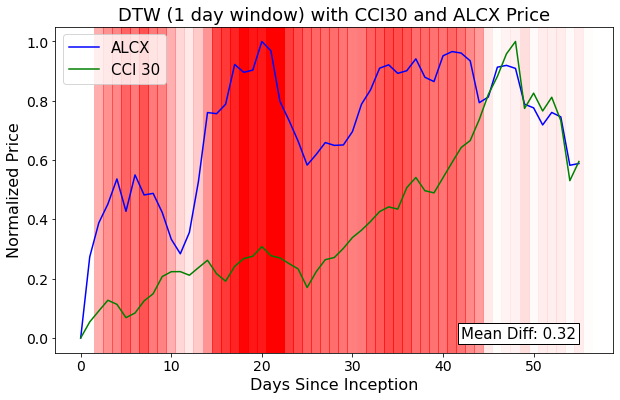

In [8]:
# Perform Dynamic Time Warping with 1-day window and plot, absolute differences
window = 1
diffs = util.doDTW(mean_alcx, market_avg, window)
util.plotCompare(mean_alcx, market_avg, diffs, window)

Now we change the window size to have a length of 4 days. In this experiment, we see the same mean cost of the DTW algorithm comapring the two series, and general trend remains consistent. We see that the previous 10 days have seen ALCX conform to virtually the same pattern than CCI30.

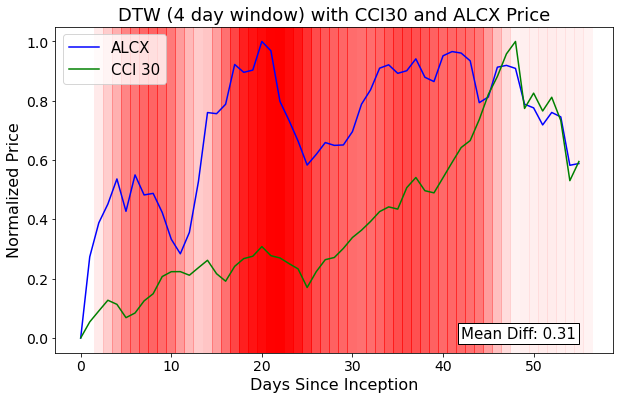

In [10]:
# Perform Dynamic Time Warping with 4-day window and plot
window = 4
diffs = util.doDTW(mean_alcx, market_avg, window)
util.plotCompare(mean_alcx, market_avg, diffs, window)

The next window size we experiment with is 8 days, just longer than week-resolution. In this experiment, we see the same mean cost of the DTW algorithm comapring the two series as the 1-day and 4-day window. We continue to see the trend of the previous 10 days, consistent with shorter windows, however notice a slight shift in the region of highest error to about 25 days after inception.

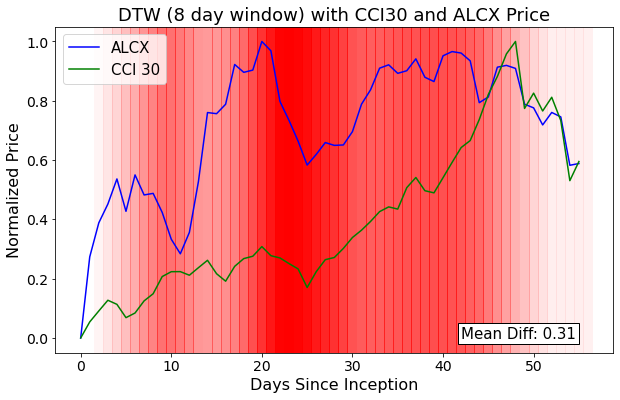

In [12]:
# Perform Dynamic Time Warping with 8-day window and plot
window = 8
diffs = util.doDTW(mean_alcx, market_avg, window)
util.plotCompare(mean_alcx, market_avg, diffs, window)

Below is the plot for a 14-day window comparison. We see the same general trands, however the area of highest cost is now centered around the 1-month mark of post-inception and we see a mean cost decrease to 0.3.

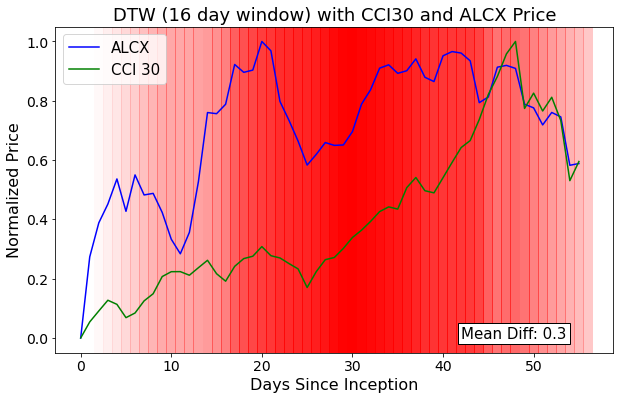

In [14]:
# Perform Dynamic Time Warping with 14-day window and plot
window = 16
diffs = util.doDTW(mean_alcx, market_avg, window)
util.plotCompare(mean_alcx, market_avg, diffs, window)

### Experiment 2: Shifting the DTW Window of Comparison

This experiment is aimed at understanding if the movement of CCI30 and help us anticipate the movement of ALCX. To do this, we offset the window using a "shift" variable, which moves the window by "shift" days to the past. Therefore, if there is less cost than the direct comparison, we would see a positive correlation for CCI30 predicting the movement of ALCX.

Our first experiment is back with the window size of 1, shifted by 1 day. We see a decrease in the overall cost from 0.32 to 0.31, suggesting that the time series is a better fit when CCI30 is used as a predictor for the movement of ALCX. We still see the general trend that the two have the lowest error towards the end of the time seris.

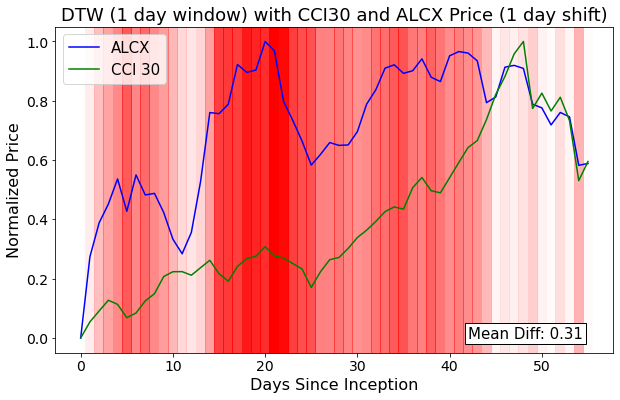

In [15]:
# shift of 1 to see if MARKET predicts ALCX price
window = 1
shift = 1
diffs = util.doDTW(mean_alcx, market_avg, window, shift)
util.plotCompare(mean_alcx, market_avg, diffs, window, shift)

Moving to the window size of 4 days and the shift of 2 days, we see the mean cost stay consistent at 0.31, the same as the window size of 1 and shift of 1, and also still less than the direct comparison without a shift.

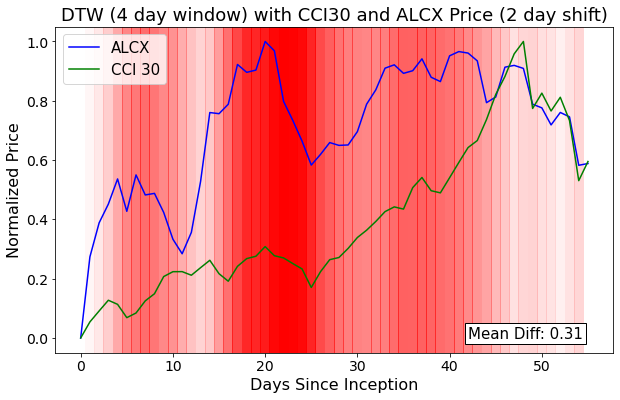

In [19]:
# Perform Dynamic Time Warping with 4-day window shifted 2 days and plot
window = 4
shift = 2
diffs = util.doDTW(mean_alcx, market_avg, window, shift)
util.plotCompare(mean_alcx, market_avg, diffs, window, shift)

We see the largest change in mean DTW cost when we increase the window size to 8 days and offset the windows by 4 days. The mean DTW cost in this case is 0.28, shown below.

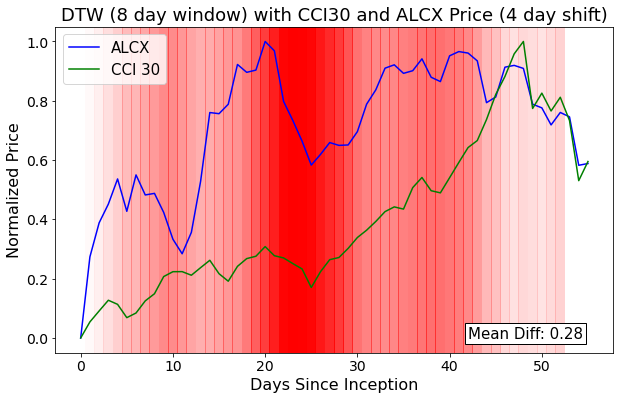

In [20]:
# Perform Dynamic Time Warping with 8-day window shifted 4 days and plot
window = 8
shift = 4
diffs = util.doDTW(mean_alcx, market_avg, window, shift)
util.plotCompare(mean_alcx, market_avg, diffs, window, shift)

Finally, when we have a window size of 16 days and shift the windows by just over a week, 8-days, we see the largest decrease in DTW cost. The mean DTW cost in this case is just 0.21, and is once again the smallest in the previous 10-20 days.

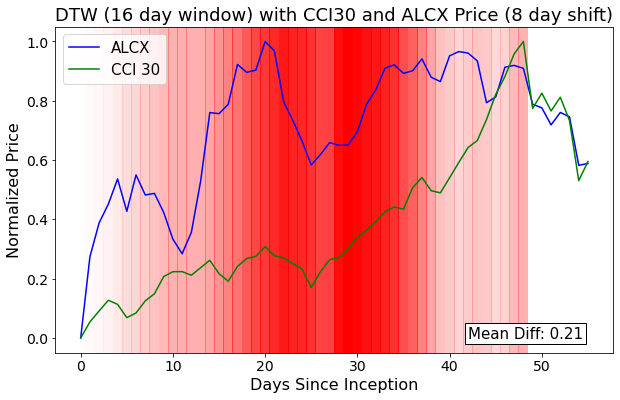

In [22]:
# Perform Dynamic Time Warping with 16-day window shifted 8 days and plot
window = 16
shift = 8
diffs = util.doDTW(mean_alcx, market_avg, window, shift)
util.plotCompare(mean_alcx, market_avg, diffs, window, shift)

## Conclusion

We have compared ALCX price data since inception with the CCI30 rules-based index showing trends in the general blockchain sector. We used Dynamic Time Warping to compare segments of 1, 4, 8, and 16 days between the two entities to determine what the most appropriate window length is. Furthermore, we found that offsetting the windows by half of their length led to lower DTW cost, meaning that the general trends of the CCI30 data could help predict the movement of ALCX better than a direct comparison. This could be helpful when anticipating how the ALCX price will change over time.

Furthermore, a general trend that was consistent across all of our experiments was the lowest cost being in the recent 10-20 days. This may suggest that, while ALCX had differences with the CCI30 shortly after inception, the currency may be maturing into a general movement trend along with the general movement of the rest of the blockchain sector. This is incredibly important information for any current or potential ALCX holder to be aware of.